# Image Generation

This section is to explore options how we generate training images for blending GPS and visual navigation, it goes through example how we can get information abot the lane we are in, intersections

In [2]:
#all imports
import carla #the sim library itself
import time # to set a delay after each photo
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import math
import sys
import random

# connect to the sim 
client = carla.Client('10.8.179.139', 2000)

# start a car
world = client.get_world()

spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Mini car
vehicle_bp = world.get_blueprint_library().filter('*model3*')

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

# make a route like in Tutorial 3
sys.path.append('C:/CARLA_0.9.14/PythonAPI/carla') # tweak to where you put carla
from agents.navigation.global_route_planner import GlobalRoutePlanner

### brief notations

In [3]:
# get actual position from the car 
vehicle_pos = vehicle.get_transform()
print(vehicle_pos)

Transform(Location(x=-64.644844, y=24.471010, z=0.001610), Rotation(pitch=0.000000, yaw=0.159198, roll=0.000000))


In [4]:
# get map look at the map
town_map = world.get_map()
roads = town_map.get_topology()

In [5]:
# make a route like in Tutorial 3
# sys.path.append('C:/CARLA_0.9.14/PythonAPI/carla') # tweak to where you put carla
# from agents.navigation.global_route_planner import GlobalRoutePlanner

point_a = start_point.location #we start at where the car is

sampling_resolution = 1
grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)

# now let' pick the longest possible route
distance = 0
for loc in spawn_points: # we start trying all spawn points 
                            #but we just exclude first at zero index
    cur_route = grp.trace_route(point_a, loc.location)
    if len(cur_route)>distance:
        distance = len(cur_route)
        route = cur_route
#draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)

In [6]:
# how we access lane info from waypoints
example_waypoint = route[0][0]
print(example_waypoint.lane_type)

Driving


In [7]:
# explore lane and junction info available for waypoints
example_junction = example_waypoint.get_junction()

In [8]:
# show where the junction is - it should draw letter J in the center of intersection in front of the car
world.debug.draw_string(example_junction.bounding_box.location, 'J', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=60.0,
        persistent_lines=True)

In [9]:
# checking lanes left and right - returns None for both
# I thought there should be right lane... never mind
example_left_lane = example_waypoint.get_left_lane()
example_right_lane = example_waypoint.get_right_lane()
print(example_left_lane,example_right_lane)

None None


In [10]:
# checking if our waypoint is intersection - True
# that must expian why we do not get right lane here
example_waypoint.is_intersection

True

In [11]:
# our waypoint is a junction too, not sure what 
#the difference is between junction and intersection
example_waypoint.is_junction

True

In [12]:
# checking lane change - it is Right, 
# meaning a change to the right is possible
print(example_waypoint.lane_change)

Right


In [13]:
# lane type is Driving as expected
example_waypoint.lane_type

carla.libcarla.LaneType.Driving

In [14]:
# lane width is 3.5
example_waypoint.lane_width

3.5

In [15]:
example_waypoint.left_lane_marking.type

carla.libcarla.LaneMarkingType.Solid

In [16]:
example_waypoint.left_lane_marking.color

carla.libcarla.LaneMarkingColor.Yellow

In [17]:
example_waypoint.left_lane_marking.width

0.125

In [18]:
# interesting right lane marking type is empty/None
# I would expect a value "Dotted" but ok
example_waypoint.right_lane_marking.type

carla.libcarla.LaneMarkingType.NONE

In [20]:
cv2.destroyAllWindows()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

### Idea

In [3]:
# finally, I got a brainwave how to make GPS and Visual happen
# Modifying previous Tutorial 4 code so the camera view shows 
# a direction/angle to a waypoint some distance away
# It is like saying "we will take left as soon as we can"
# so even we still need to go straight for a bit, we will get
# a new direction we will need to take as soon as we can

# Try running this to see what I mean - pay attention to car's camera
# You will see how General Direction angle gives "Advance heads-up"
# what we will need to be doing next

#clean up
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

SPEED_THRESHOLD = 2 #defines when we get close to desired speed so we drop the

# Max steering angle
MAX_STEER_DEGREES = 40
# This is max actual angle with Mini under steering input=1.0
STEERING_CONVERSION = 75

#camera mount offset on the car - you can tweak these to have the car in view or not
CAMERA_POS_Z = 3 
CAMERA_POS_X = -5 

#adding params to display text to image
font = cv2.FONT_HERSHEY_SIMPLEX
# org - defining lines to display telemetry values on the screen
org = (30, 30) # this line will be used to show current speed
org2 = (30, 50) # this line will be used for future steering angle
org3 = (30, 70) # and another line for future telemetry outputs
org4 = (30, 90) # and another line for future telemetry outputs
org3 = (30, 110) # and another line for future telemetry outputs
fontScale = 0.5
# white color
color = (255, 255, 255)
# Line thickness of 2 px
thickness = 1

# utility function for camera listening 
def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

# maintain speed function
def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.9 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 


# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function returns degrees between the car's direction 
    and direction to a selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    # extra checks on predicted angle when values close to 360 degrees are returned
    if degrees<-180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    return degrees

def get_proper_angle(car,wp_idx,rte):
    '''
    This function uses simple fuction above to get angle but for current
    waypoint and a few more next waypoints to ensure we have not skipped
    next waypoint so we avoid the car trying to turn back
    '''
    # create a list of angles to next 5 waypoints starting with current
    next_angle_list = []
    for i in range(10):
        if wp_idx + i*3 <len(rte)-1:
            next_angle_list.append(get_angle(car,rte[wp_idx + i*3][0]))
    idx = 0
    while idx<len(next_angle_list)-2 and abs(next_angle_list[idx])>40:
        idx +=1
    return wp_idx+idx*3,next_angle_list[idx]  

def get_distant_angle(car,wp_idx,rte, delta):
    '''
    This function modifies the fuction above to get angle to a waypoint
    at a distance so we could use it for training image generation
    
    We will display the angle for now in the 'telemetry' view so
    we could play with how far forward we need to pick the waypoint
    '''
    if wp_idx + delta < len(rte)-1:
        i = wp_idx + delta
    else:
        i = len(rte)-1
    # check for intersection within the "look forward"
    # so we do not give turn results when just following the road
    intersection_detected = False
    for x in range(i-wp_idx):
        if rte[wp_idx+x][0].is_junction:
             intersection_detected = True
    angle = get_angle(car,rte[i][0])
    if not intersection_detected:
        result = 0
    elif angle <-10:
        result = -1
    elif angle>10:
        result =1
    else:
        result = 0    
    return result

def draw_route(wp, route,seconds=3.0):
    #draw the next few points route in sim window - Note it does not
    # get into the camera of the car
    if len(route)-wp <25: # route within 25 points from end is red
        draw_colour = carla.Color(r=255, g=0, b=0)
    else:
        draw_colour = carla.Color(r=0, g=0, b=255)
    for i in range(10):
        if wp+i<len(route)-2:
            world.debug.draw_string(route[wp+i][0].transform.location, '^', draw_shadow=False,
                color=draw_colour, life_time=seconds,
                persistent_lines=True)
    return None


def select_random_route(position,locs):
    '''
    retruns a random route for the car/veh
    out of the list of possible locations locs
    where distance is longer than 100 waypoints
    '''    
    point_a = position.location #we start at where the car is or last waypoint
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
    # now let' pick the longest possible route
    min_distance = 100
    result_route = None
    route_list = []
    for loc in locs: # we start trying all spawn points 
                                #but we just exclude first at zero index
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    result_route = random.choice(route_list)
    return result_route

world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Tesla m3 car
vehicle_bp = world.get_blueprint_library().filter('*model3*')

In [3]:
def exit_clean():
    #clean up
    cv2.destroyAllWindows()
    camera.stop()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    return None

#main loop
quit = False
while True:
    start_point = random.choice(spawn_points)
    vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
    time.sleep(2)
    #setting RGB Camera - this follow the approach explained in a Carla video
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
    camera_bp.set_attribute('image_size_y', '360')
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    #this creates the camera in the sim
    camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
    image_w = camera_bp.get_attribute('image_size_x').as_int()
    image_h = camera_bp.get_attribute('image_size_y').as_int()
    camera_data = {'image': np.zeros((image_h,image_w,4))}
    # this actually opens a live stream from the camera
    camera.listen(lambda image: camera_callback(image,camera_data))
    cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
    cv2.imshow('RGB Camera',camera_data['image'])
    # getting a random route for the car
    route = select_random_route(start_point,spawn_points)
    curr_wp = 5 #we will be tracking waypoints in the route and switch to next one when we get close to current one
    predicted_angle = 0
    PREFERRED_SPEED = 40 # setting speed at start of new route
    
    while curr_wp<len(route)-1:
        # Carla Tick
        world.tick()
        draw_route(curr_wp, route,1)
        if cv2.waitKey(1) == ord('q'):
            quit = True
            exit_clean()
            break
        image = camera_data['image']
        if curr_wp >=len(route)-10: # within 10 points of end, the route is done
            PREFERRED_SPEED = 0 # seeting speed to 0 after completing one route
            exit_clean()
            break
        while curr_wp<len(route)-2 and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
            curr_wp +=1 #move to next wp if we are too close
        curr_wp, predicted_angle = get_proper_angle(vehicle,curr_wp,route)
        distant_angle = get_distant_angle(vehicle,curr_wp,route,30)
        image = cv2.putText(image, 'Steering angle: '+str(round(predicted_angle,1)), org, font, fontScale, color, thickness, cv2.LINE_AA)
        v = vehicle.get_velocity()
        speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)
        image = cv2.putText(image, 'Speed: '+str(int(speed)), org3, font, fontScale, color, thickness, cv2.LINE_AA)
        image = cv2.putText(image, 'General Direction: '+str(distant_angle), org2, font, fontScale, color, thickness, cv2.LINE_AA)
        estimated_throttle = maintain_speed(speed)

        steer_input = predicted_angle
        # limit steering to max angel, say 40 degrees
        if predicted_angle<-MAX_STEER_DEGREES:
            steer_input = -MAX_STEER_DEGREES
        elif predicted_angle>MAX_STEER_DEGREES:
            steer_input = MAX_STEER_DEGREES
        # conversion from degrees to -1 to +1 input for apply control function is applied below in steering input
        vehicle.apply_control(carla.VehicleControl(throttle=estimated_throttle, steer=steer_input/STEERING_CONVERSION))
        cv2.imshow('RGB Camera',image)
    if quit:
        break

The plan from here:
The code above needs to change to generate images With semantic segmentation image, we need to add:

1. Precise angle we need to get from the model (predicition) - aka. Y or labels. This angle will be taken from what we apply to the car using waypoints as before
2. General/advance direction angle we just added above. This will be our second input into predictions (x1 is image, x2 is general direction). We simplified this angle to represent (straight/follow=0, left=-1 or right=1)

Limitation: lane changes, which are quite abrupt may impact the quality of training images where general direction may be impacted

### Image generation

In [4]:
def select_random_route(position,locs):
    '''
    retruns a random route for the car/veh
    out of the list of possible locations locs
    where distance is longer than 100 waypoints
    '''    
    point_a = position.location #we start at where the car is or last waypoint
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
    # now let' pick the longest possible route
    min_distance = 100
    max_distance = 140
    result_route = None
    route_list = []
    for loc in locs: # we start trying all spawn points 
                                #but we just exclude first at zero index
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance and len(cur_route) < max_distance:
            route_list.append(cur_route)
    result_route = random.choice(route_list)
    return result_route

#### process

In [28]:
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
spawn_points = world.get_map().get_spawn_points()
x = random.randint(0,len(spawn_points)-1)
start_point = spawn_points[x]
route = select_random_route(start_point,spawn_points)
# draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=5.0,
        persistent_lines=True)

In [29]:
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=125.0,
        persistent_lines=True)

In [30]:
start_intersection = 0
for i, waypoint in enumerate(route):
    if (route[i][0].is_junction or route[i][0].is_intersection) and start_intersection==0:
        start_intersection = i
        break
print('intersection begins at point:', i)

intersection begins at point: 54


In [31]:
world.debug.draw_string(route[start_intersection][0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=125.0,
        persistent_lines=True)

In [32]:
temp_wp = route[start_intersection][0] # same as above
print(temp_wp.lane_type)

Driving


In [33]:
# this is how to get entry and exit points from an intersection
my_junction = temp_wp.get_junction()
junction_wps = my_junction.get_waypoints(carla.LaneType.Driving)
for waypoint in junction_wps:
    #entry points
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=125.0,
        persistent_lines=True)
    #exit points
    world.debug.draw_string(waypoint[1].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=255, g=0, b=0), life_time=125.0,
        persistent_lines=True)

![스크린샷 2025-01-14 163230.png](<attachment:스크린샷 2025-01-14 163230.png>)
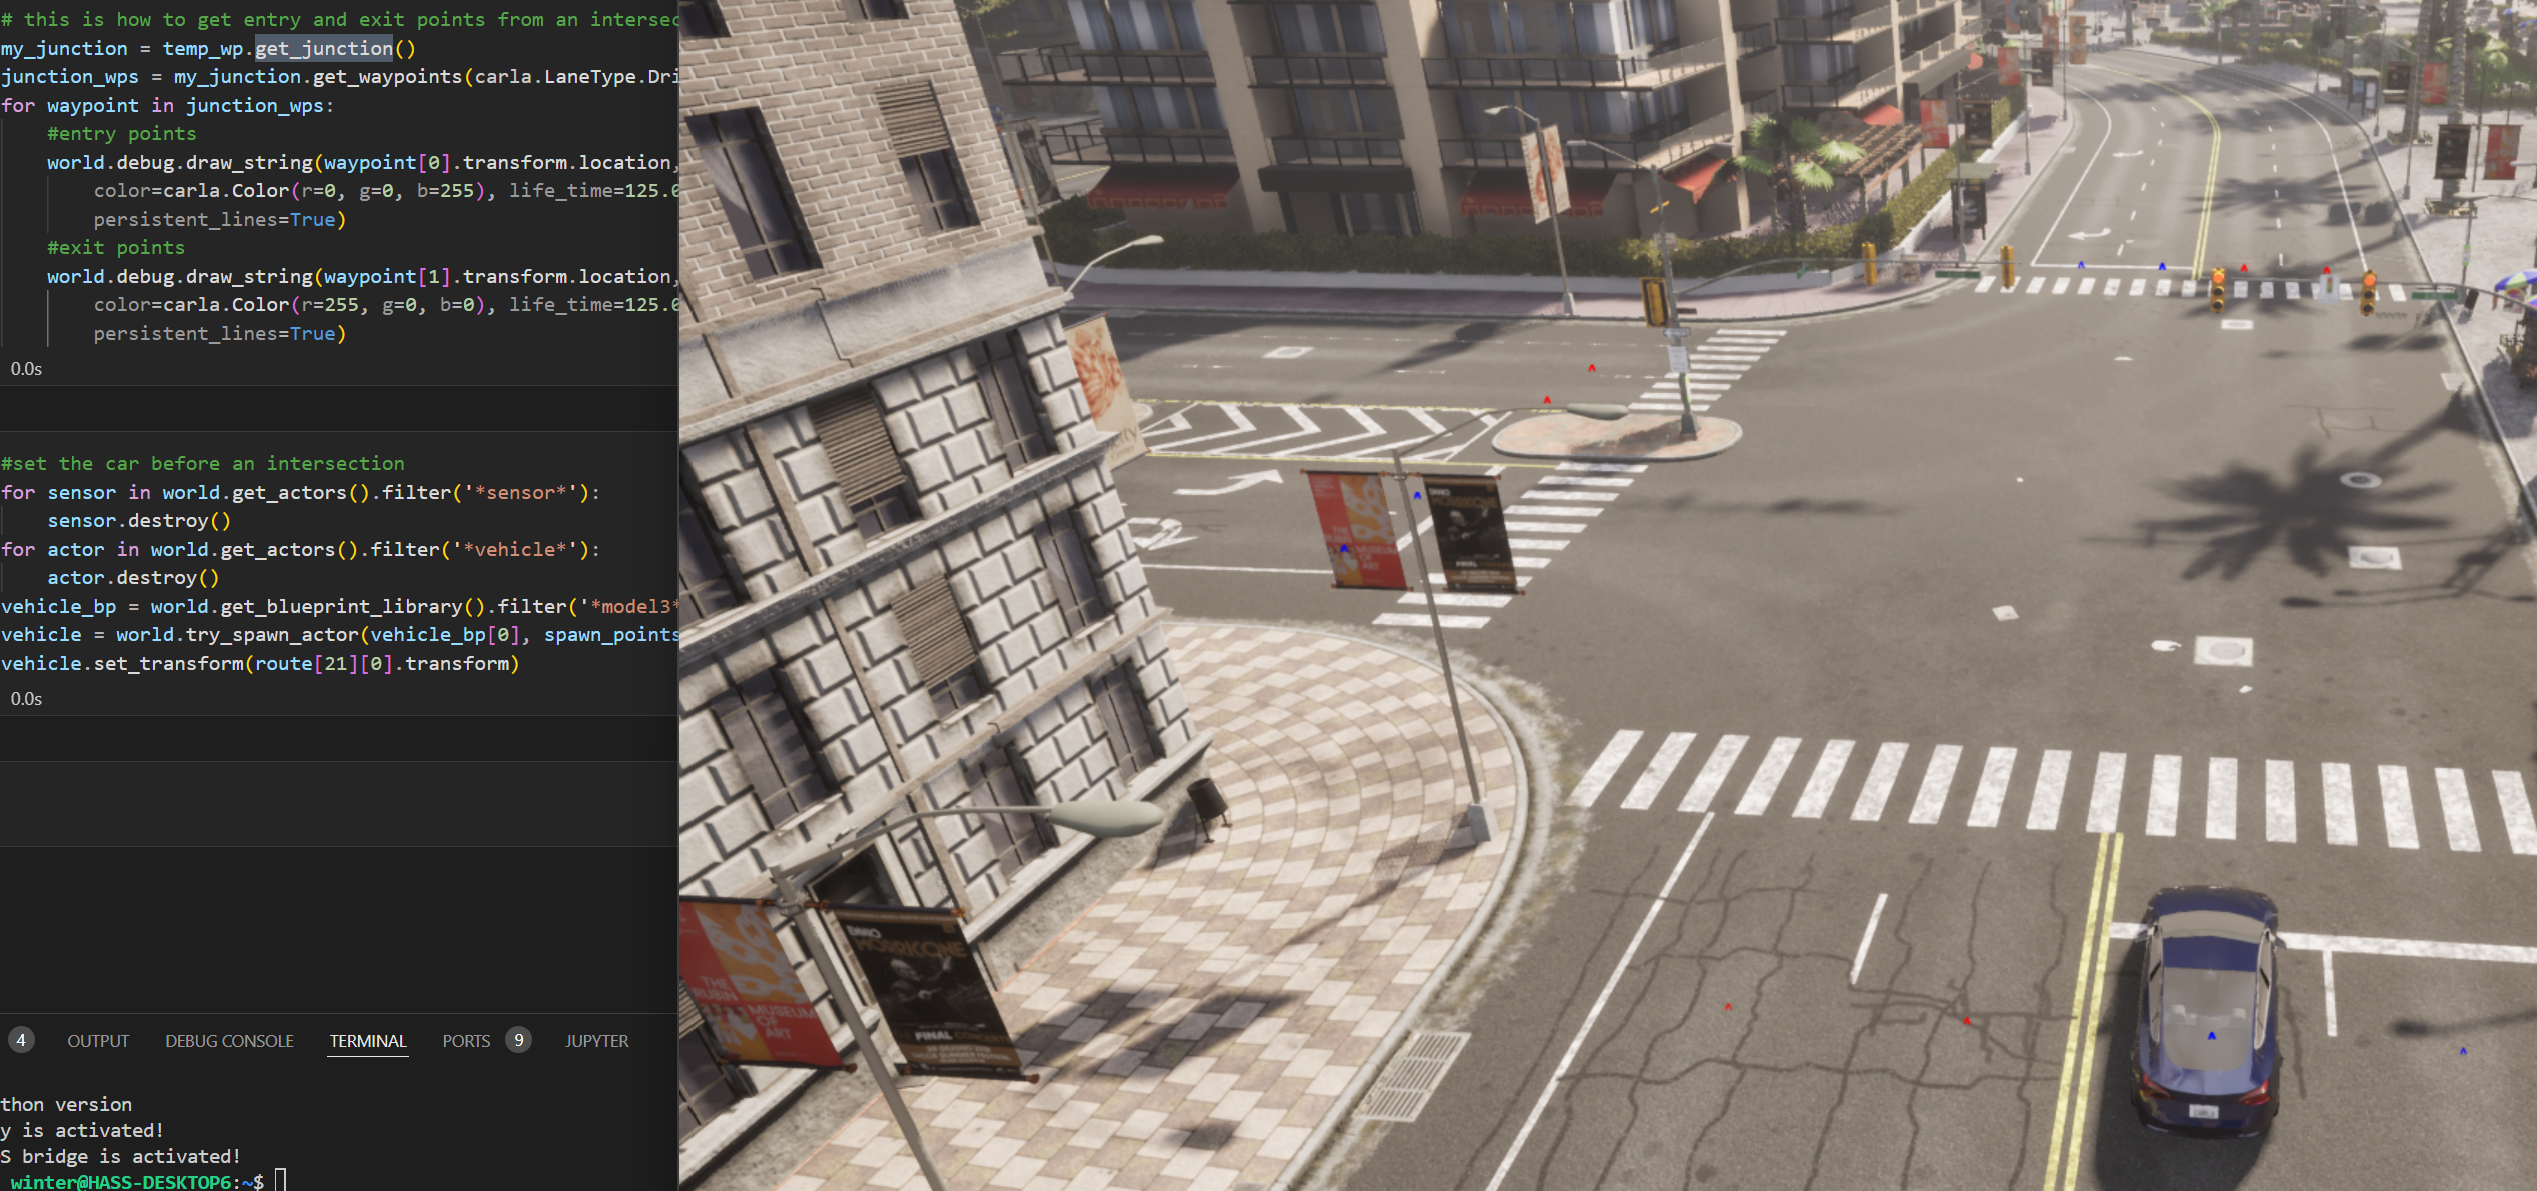

In [34]:
#set the car before an intersection
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
vehicle_bp = world.get_blueprint_library().filter('*model3*')
vehicle = world.try_spawn_actor(vehicle_bp[0], spawn_points[0])
vehicle.set_transform(route[21][0].transform)

In [35]:
#find possible exists from a junction which are not U turns 
angles_planned = [] # this is a list of angles towards current exit from the intersection
all_angles = []
for wp in junction_wps:
    angle = int(get_angle(vehicle,wp[1])) 
    if abs(angle)<60: #this excludes exits for which you would need to take u-turns so they do not count
        # check all exits for proximity to our route so we can flag the exit we are planning to take
        for i in range(77,len(route)-1):
            if wp[1].transform.location.distance(route[i][0].transform.location) < 10:
                angles_planned.append(angle)
            else:
                all_angles.append(angle)
angles_planned = list(set(angles_planned))
all_angles = list(set(all_angles))
alternative_angles = [item for item in all_angles if item not in angles_planned] 

try:
    if min(angles_planned)<-25 and (min(alternative_angles) > min(angles_planned)):
        #we are planningleft turn
        direction = -1
    elif max(angles_planned)>25 and (max(alternative_angles) < max(angles_planned)):
        direction = 1
    else:
        direction = 0 
except ValueError:
    print('Cannot set the direction')

#### total

In [6]:
# test image gen on a short route
# to confirm lane change points are ignored

CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 

CAM_HEIGHT = 480
CAM_WIDTH = 640
FOV = 90 # field of view = focal length

YAW_ADJ_DEGREES = 25 #random spin angle max

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

def cleanup():
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for actor in world.get_actors().filter('*sensor*'):
        actor.destroy()

# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function returns degrees between the car's direction 
    and direction to a selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    if ((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5 == 0:
        x=0
        y=0
    else:
        x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
        y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
        
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    # extra checks on predicted angle when values close to 360 degrees are returned
    if degrees<-180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    return degrees


def get_distant_angle(car,wp_idx,rte, delta):
    '''
    This function modifies the function above to get angle to a waypoint
    at a distance so we could use it for training image generation
    
    We will display the angle for now in the 'telemetry' view so
    we could play with how far forward we need to pick the waypoint
    '''
    if wp_idx + delta < len(rte)-1:
        i = wp_idx + delta
    else:
        i = len(rte)-1
    # check for intersection within the "look forward"
    # so we do not give turn results when just following the road
    intersection_detected = False
    for x in range(i-wp_idx):
        if rte[wp_idx+x][0].is_junction:
             intersection_detected = True
    angle = get_angle(car,rte[i][0])
    if not intersection_detected:
        result = 0
    elif angle <-10:
        result = -1
    elif angle>10:
        result =1
    else:
        result = 0    
    return result

def draw_route(wp, route,seconds=3.0):
    #draw the next few points route in sim window - Note it does not
    # get into the camera of the car
    if len(route)-wp <25: # route within 25 points from end is red
        draw_colour = carla.Color(r=255, g=0, b=0)
    else:
        draw_colour = carla.Color(r=0, g=0, b=255)
    for i in range(10):
        if wp+i<len(route)-2:
            world.debug.draw_string(route[wp+i][0].transform.location, '^', draw_shadow=False,
                color=draw_colour, life_time=seconds,
                persistent_lines=True)
    return None



for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

# set the car before the intersection
spawn_points = world.get_map().get_spawn_points()
x = random.randint(0,len(spawn_points)-1)
start_point = spawn_points[x]
route = select_random_route(start_point,spawn_points)

start_intersection = 0
for i, waypoint in enumerate(route):
    if (route[i][0].is_junction or route[i][0].is_intersection) and start_intersection==0:
        start_intersection = i
        break

vehicle_bp = world.get_blueprint_library().filter('*model3*')
vehicle = world.try_spawn_actor(vehicle_bp[0], spawn_points[0])
vehicle.set_transform(route[start_intersection][0].transform)



#RGB CAM
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', str(CAM_WIDTH)) # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
camera_bp.set_attribute('fov', str(FOV))
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()
camera_data = {'image': np.zeros((image_h,image_w,3)),
            'sem_image': np.zeros((image_h,image_w,3))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

#Semantgic cam
sem_camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
sem_camera_bp.set_attribute('image_size_x', str(CAM_WIDTH)) # this ratio works in CARLA 9.14 on Windows
sem_camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
sem_camera_bp.set_attribute('fov', str(FOV))
#this creates the camera in the sim
sem_camera = world.spawn_actor(sem_camera_bp,camera_init_trans,attach_to=vehicle)
image_w = sem_camera_bp.get_attribute('image_size_x').as_int()
image_h = sem_camera_bp.get_attribute('image_size_y').as_int()
sem_camera_data = {'image': np.zeros((image_h,image_w,3))}
# this actually opens a live stream from the camera
#sem_camera.listen(lambda image: camera_callback(image,sem_camera_data))
sem_camera.listen(lambda image: sem_callback(image,camera_data))

# cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
# cv2.imshow('RGB Camera',camera_data['image'])
cv2.namedWindow('Semantic Camera', cv2.WINDOW_AUTOSIZE)
cv2.imshow('Semantic Camera', camera_data['sem_image'])

spectator = world.get_spectator()
#make a route

for idx, waypoint in enumerate(route): # move the car through the route
    
    transform = waypoint[0].transform
    vehicle.set_transform(transform)
    vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
    time.sleep(2) #these delays seem to be necessary for teh car to take the position before a shot is taken
    initial_yaw = waypoint[0].transform.rotation.yaw
    
    lane_change = False
    if not waypoint[0].is_intersection and not waypoint[0].is_junction:
        if idx < len(route)-2:
            if route[idx][0].lane_id != route[idx+1][0].lane_id:
                lane_change = True
                print('lane_change detected')
    if not lane_change:
        for i in range(5): # five different angle
            trans = waypoint[0].transform
            angle_adj = random.randrange(-YAW_ADJ_DEGREES, YAW_ADJ_DEGREES, 1)
            trans.rotation.yaw = initial_yaw +angle_adj 
            vehicle.set_transform(trans)
            vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
            time.sleep(1)  #these delays seem to be necessary for the car to take the position before a shot is taken
            gen_dir_angle = get_distant_angle(vehicle,idx,route,30) # general angle taken
            if cv2.waitKey(1) == ord('q'):
                quit = True
                break

            # Spectator Update
            spectator_transform = vehicle.get_transform()
            spectator_transform.location += carla.Location(x=0, y=0, z=15)
            spectator_transform.rotation.yaw += -15  # left
            spectator_transform.rotation.pitch = -90 # downward
            spectator.set_transform(spectator_transform)
            # Display with imshow
            # cv2.imshow('RGB Camera',camera_data['image'])
            cv2.imshow('Semantic Camera', camera_data['sem_image'])

            # save semantic image watching out for end of route    
            if idx + 5 < len(route)-1:
                predicted_angle = get_angle(vehicle,route[idx+5][0]) # get the angle to +5 waypoint ahead of us
                
                time_grab = time.time_ns()
                sem_image = camera_data['sem_image']
                if np.sum(sem_image) > 0:   #check for black images
                    cv2.imwrite('_img/%06d_%s_%s.png' % (time_grab, gen_dir_angle,round(predicted_angle,0)), sem_image)

cv2.destroyAllWindows()
cleanup()

lane_change detected


In [7]:
# test gen direction at intersections
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

#RGB CAM
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', str(CAM_WIDTH)) # this ratio works in CARLA 9.14 on Windows
camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
camera_bp.set_attribute('fov', str(FOV))
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()
camera_data = {'image': np.zeros((image_h,image_w,3)),
            'sem_image': np.zeros((image_h,image_w,3))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

#Semantgic cam
sem_camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
sem_camera_bp.set_attribute('image_size_x', str(CAM_WIDTH)) # this ratio works in CARLA 9.14 on Windows
sem_camera_bp.set_attribute('image_size_y', str(CAM_HEIGHT))
sem_camera_bp.set_attribute('fov', str(FOV))
#this creates the camera in the sim
sem_camera = world.spawn_actor(sem_camera_bp,camera_init_trans,attach_to=vehicle)
image_w = sem_camera_bp.get_attribute('image_size_x').as_int()
image_h = sem_camera_bp.get_attribute('image_size_y').as_int()
sem_camera_data = {'image': np.zeros((image_h,image_w,3))}
# this actually opens a live stream from the camera
#sem_camera.listen(lambda image: camera_callback(image,sem_camera_data))
sem_camera.listen(lambda image: sem_callback(image,camera_data))

cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
cv2.imshow('RGB Camera',camera_data['image'])
#make a route

gen_dir_angle = 0 # in case we did not get a general GPS direction
for idx, waypoint in enumerate(route): # move the car through the route
    
    transform = waypoint[0].transform
    vehicle.set_transform(transform)
    vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
    time.sleep(2) #these delays seem to be necessary for teh car to take the position before a shot is taken
    initial_yaw = waypoint[0].transform.rotation.yaw
    # GPS general direction is only taken outside intersections
    # so that direction is retained throughout the same intersection until it is finished
    if not waypoint[0].is_intersection and not waypoint[0].is_junction:
        gen_dir_angle = get_distant_angle(vehicle,idx,route,30) # general angle
    # logic to detect a lane change and ignore/not take those images
    lane_change = False
    if not waypoint[0].is_intersection and not waypoint[0].is_junction:
        if idx < len(route)-2:
            if route[idx][0].lane_id != route[idx+1][0].lane_id:
                lane_change = True
    if not lane_change:
        for i in range(5):
            trans = waypoint[0].transform
            angle_adj = random.randrange(-YAW_ADJ_DEGREES, YAW_ADJ_DEGREES, 1)
            trans.rotation.yaw = initial_yaw +angle_adj 
            vehicle.set_transform(trans)
            vehicle.apply_control(carla.VehicleControl(throttle=0, steer=0, brake=1))
            time.sleep(1)  #these delays seem to be necessary for the car to take the position before a shot is taken
            
            if cv2.waitKey(1) == ord('q'):
                quit = True
                break
            # Display with imshow
            cv2.imshow('RGB Camera',camera_data['image'])
            # save semantic image watching out for end of route    
            if idx + 5 < len(route)-1:
                predicted_angle = get_angle(vehicle,route[idx+5][0]) # get the angle to +5 waypoint ahead of us
                
                time_grab = time.time_ns()
                sem_image = camera_data['sem_image']
                if np.sum(sem_image) > 0:   #check for black images
                    cv2.imwrite('_img/%06d_%s_%s.png' % (time_grab, gen_dir_angle,round(predicted_angle,0)), sem_image)
cv2.destroyAllWindows()
cleanup()

### Verify the image generation process

In [60]:
# latest get direction function
def get_distant_angle(car,wp_idx,rte, delta):
    '''
    This function determines general direction
    given what we are planning to do at an oncoming intersection
    so if we are within delta points from an intersection
    we check our route at the intersection to decide what we do at it
    '''
    if wp_idx + delta < len(rte)-1:
        i = wp_idx + delta
    else:
        i = len(rte)-1
    # check for intersection within the "look forward"
    # so we do not give turn results when just following the road
    intersection_detected = False
    for x in range(i-wp_idx):
        if rte[wp_idx+x][0].is_junction:
             intersection_detected = True
             intersection_ref = wp_idx+x
             break
    if not intersection_detected:
        result = 0
    else: #we check out the intersection
        angles_planned = [] # this is a list of angles towards current exit from the intersection
        all_angles = []
        #this is how to get all waypoints defining an intersection
        junction_wps = rte[intersection_ref][0].get_junction().get_waypoints(carla.LaneType.Driving)
        for wp in junction_wps:
            angle = int(get_angle(car,wp[1])) 
            #this 'if' below excludes close exits points to entry - exits for which you would need to take u-turns so they do not count
            if wp[1].transform.location.distance(route[intersection_ref][0].transform.location) > 20: 
                # check all exits for proximity to our route so we can flag the exit we are planning to take
                for i in range(intersection_ref,len(route)-1):
                    if wp[1].transform.location.distance(route[i][0].transform.location) < 10:
                        angles_planned.append(angle)
                    else:
                        all_angles.append(angle)
        angles_planned = list(set(angles_planned))
        all_angles = list(set(all_angles))
        alternative_angles = [item for item in all_angles if item not in angles_planned] 
        if len(alternative_angles)== 0:
            result = 0
        elif min(angles_planned)<-25 and (min(alternative_angles) > min(angles_planned)):
            #we are planningleft turn
            result = -1
        elif max(angles_planned)>25 and (max(alternative_angles) < max(angles_planned)):
            result = 1
        else:
            result = 0  
    return result

In [63]:
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=125.0,
        persistent_lines=True)

In [65]:
vehicle_bp = world.get_blueprint_library().filter('*model3*')
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

temp_wp = 30
vehicle.set_transform(route[temp_wp][0].transform)
get_distant_angle(vehicle,temp_wp,route,40)

1

In [75]:
# generate interesting routes -> try this until the value is existing
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
spawn_points = world.get_map().get_spawn_points()
x = random.randint(0,len(spawn_points)-1)
start_point = spawn_points[x]
route = select_random_route(start_point,spawn_points)
#draw the route in sim window - Note it does not get into the camera of the car
for waypoint in route:
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=0, g=0, b=255), life_time=5.0,
        persistent_lines=True)

In [76]:
#debug function
wp_idx = 65
delta = 30
rte = route
if wp_idx + delta < len(rte)-1:
    i = wp_idx + delta
else:
    i = len(rte)-1
# check for intersection within the "look forward"
# so we do not give turn results when just following the road
intersection_detected = False
for x in range(i-wp_idx):
    if rte[wp_idx+x][0].is_junction:
            intersection_detected = True
            intersection_ref = wp_idx+x
            break
if not intersection_detected:
    result = 0
else: # we check out the intersection
    angles_planned = [] # this is a list of angles towards current exit from the intersection
    all_angles = []
    # this is how to get all waypoints defining an intersection
    junction_wps = rte[intersection_ref][0].get_junction().get_waypoints(carla.LaneType.Driving)
    for wp in junction_wps:
        angle = int(get_angle(vehicle,wp[1])) 
        
        if wp[1].transform.location.distance(route[intersection_ref][0].transform.location) > 20: # this excludes close points - exits for which you would need to take u-turns so they do not count
            world.debug.draw_string(wp[1].transform.location, '^', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=60.0,
                persistent_lines=True)
            # check all exits for proximity to our route so we can flag the exit we are planning to take
            for i in range(intersection_ref,len(route)-1):
                if wp[1].transform.location.distance(route[i][0].transform.location) < 10:
                    angles_planned.append(angle)
                else:
                    all_angles.append(angle)
    angles_planned = list(set(angles_planned))
    all_angles = list(set(all_angles))
    alternative_angles = [item for item in all_angles if item not in angles_planned] 
    if len(alternative_angles)== 0:
        result = 0
    elif min(angles_planned)<-25 and (min(alternative_angles) > min(angles_planned)):
        #we are planningleft turn
        result = -1
    elif max(angles_planned)>25 and (max(alternative_angles) < max(angles_planned)):
        result = 1
    else:
        result = 0 
    print(result) 

0


In [77]:
print(result)
print(intersection_ref)
print(all_angles)
print(alternative_angles)
print(angles_planned)
world.debug.draw_string(rte[intersection_ref][0].transform.location, '^', draw_shadow=False,
    color=carla.Color(r=0, g=0, b=255), life_time=5.0,
    persistent_lines=True)

0
85
[23, -2, 22]
[23, 22]
[-2]


In [79]:
for waypoint in junction_wps:
    #entry points
    world.debug.draw_string(waypoint[0].transform.location, '^', draw_shadow=False,
       color=carla.Color(r=0, g=0, b=255), life_time=125.0,
       persistent_lines=True)
    #exit points
    world.debug.draw_string(waypoint[1].transform.location, '^', draw_shadow=False,
        color=carla.Color(r=255, g=0, b=0), life_time=60.0,
        persistent_lines=True)

![스크린샷 2025-01-14 171838.png](<attachment:스크린샷 2025-01-14 171838.png>)
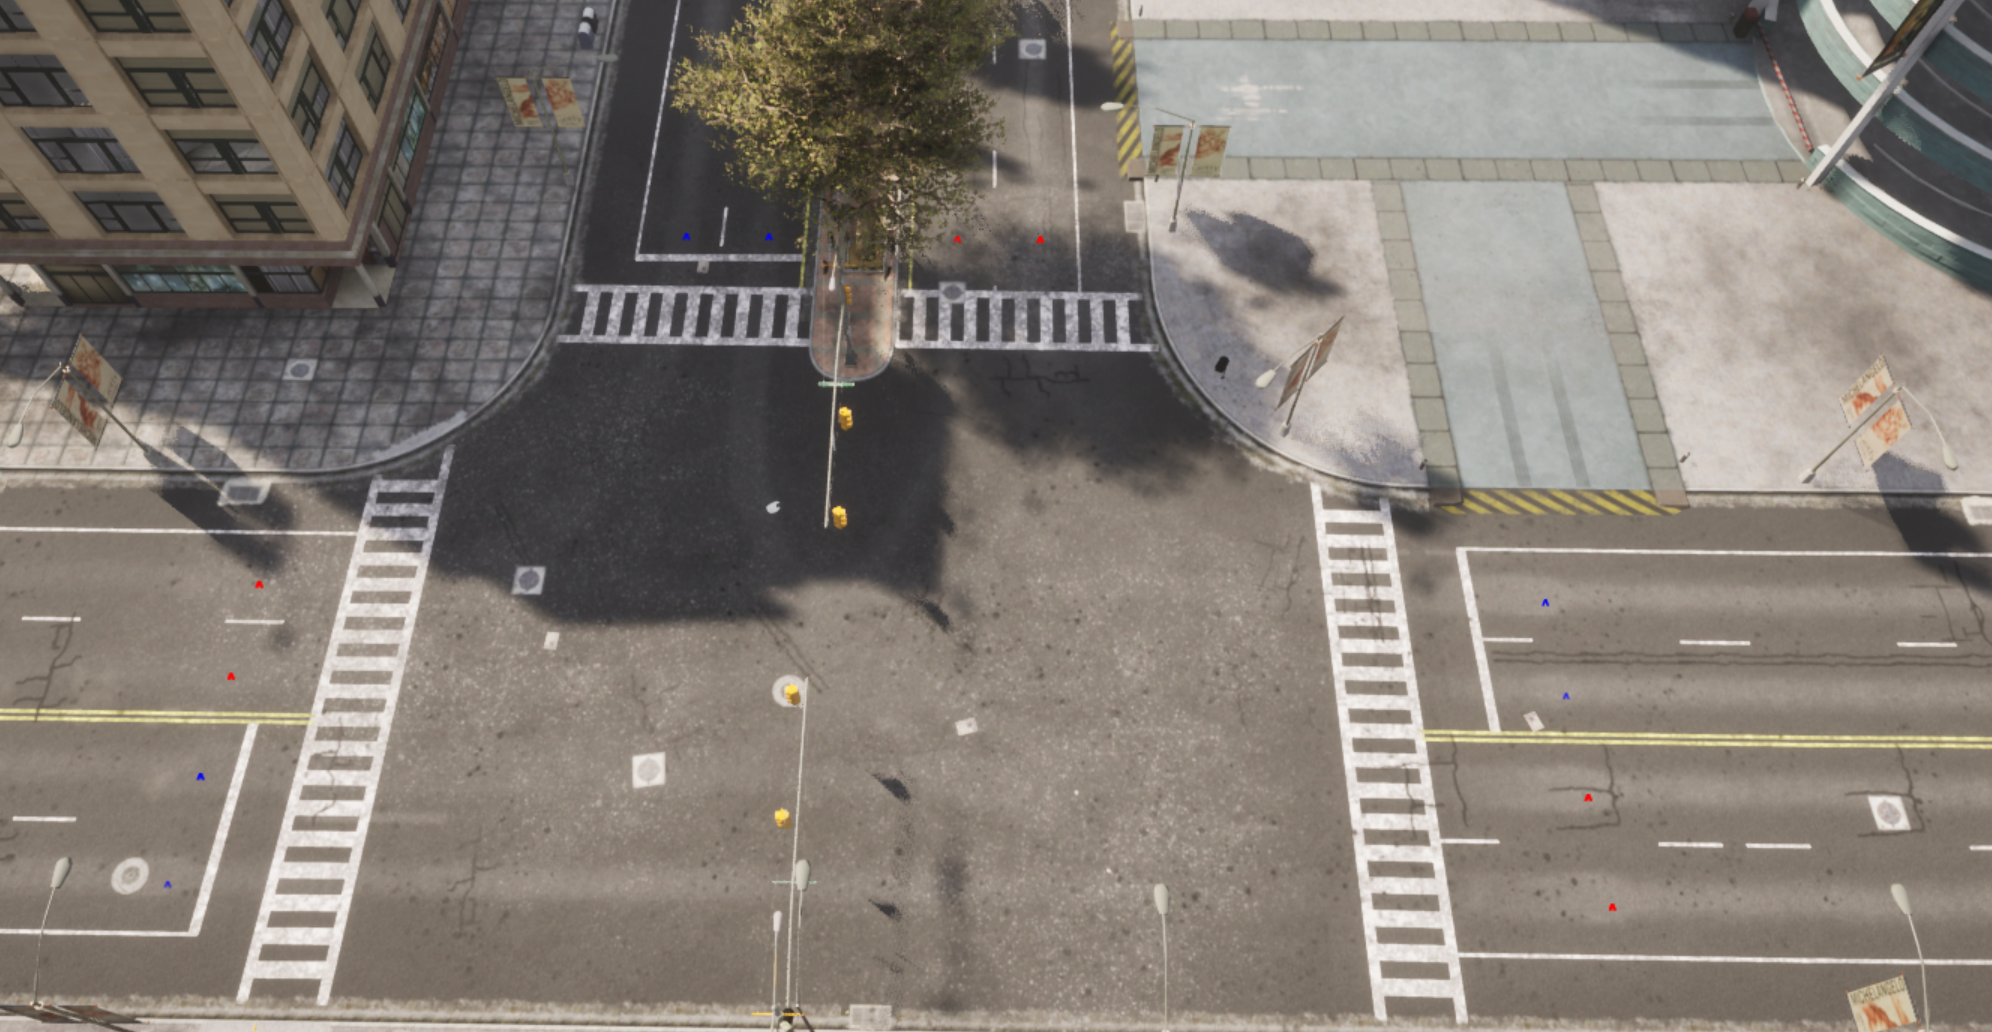